# 🎓[Training] Student Perf from Gameplay
---
In this notebook, I used the baseline of Chris Deotte based on the idea proposed by DataManyo. You can check out there respective works:
- [XGBoost Baseline - [0.676]](https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-676/notebook)
- [🥇 LightGBM baseline with aggregated log data](https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data)


I will keep track of my progress during the start of the competition. My goal now is to improve this baseline by suggesting improvements.

## ✨Progress
- ***Baseline: LB Score:* 0.676**
 - Training using 18 XGBoost models for individual questions.
 - The data is grouped into 3 groups of questions and statistics of the features are calculated.
 - Cross validation on 5 folds and training on 80% of the data (last fold).
- ***Increasing number of CV folds:* LB Score: 0.677**
 - Using 20 folds for cross-validation and training on 95% of the data [(Chris Deotte suggestion)](https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-676/comments#2146075).
 - Tried with 10 folds - LB Score: 0.676
- ***Training on full data:* LB Score:**
 - Averaging the `best_ntree_limit` along the folds for each question.
 - Try with 5, 10, 20 folds for the average


# Imports

In [1]:
import os

# Standard libraries
import pandas as pd
# import cudf as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Other libraries
from tqdm.notebook import tqdm
import pickle

# Configuration
pd.set_option('display.max_columns', None)

# Parameters
Here are the parameters related to the model strategy.
- `xgb_params`: You can check the different parameters available for XGBoost. Check the documentation [here](https://xgboost.readthedocs.io/en/stable/).
- `SAVE`: Save the 'models' dictionnary as pickle file.
- `N_FOLDS`: Number of folds for the cross-validation.
- `RETRAIN_WITH_ALL_DATA`: Retrain or not a final model using all of the data, with the number of estimators for each model determined by the averages obtained during cross-validation. If set to False, the final model is trained using the exact numbers of estimators but on the last fold of cross-validation.
- `INFERENCE`: Choose to use this notebook for inference. Flase recommended.

The inference

In [23]:
# Model params
xgb_params = {'objective': 'binary:logistic',
              'eval_metric': 'logloss',
              'learning_rate': 0.05,
              'max_depth': 4,
              'n_estimators': 1000,
              'early_stopping_rounds': 50,
              'tree_method': 'hist',
              'subsample': 0.8,
              'colsample_bytree': 0.4,
              'use_label_encoder': False}

# Save the models as pickle
SAVE = True

# Cross validation
N_FOLDS = 5

# Retrain using all data
RETAIN_WITH_ALL_DATA = False

# Use as inference notebook (False recommended)
INFERENCE = False

# Read the data

In [4]:
%%time
PATH = '/kaggle/input/predict-student-performance-from-game-play'

train = pd.read_csv(f'{PATH}/train.csv')
labels = pd.read_csv(f'{PATH}/train_labels.csv')

# Separate session and question from session_id
labels['session'] = labels['session_id'].apply(lambda x: int(x.split('_')[0]))
labels['question'] = labels['session_id'].apply(lambda x: int(x.split('_')[1][1:]))
labels.sample(frac=1).head()

CPU times: user 23.3 s, sys: 3.73 s, total: 27 s
Wall time: 52.8 s


,session_id,correct,session,question
149663,21090509233214650_q13,0,21090509233214650,13
108392,21000513215954290_q10,0,21000513215954290,10
156440,21010510374894904_q14,0,21010510374894904,14
193065,21030110372115720_q17,1,21030110372115720,17
165481,20100514243502560_q15,0,20100514243502560,15


In [5]:
train.head(1)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4


# Feature engineering
I will use the idea of aggreagating the data by `session_id` and `level_group`. Check out the references at the beginning of the notebook.

The aim is to create interesting features from these groups that we can use to train one model per question level.

In [6]:
CATS = ['event_name', 'fqid', 'room_fqid', 'text']
NUMS = ['elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

In [7]:
'object_hover'
'notebook_click'

'notebook_click'

In [8]:
def feature_engineer(train):
    dfs = []
    group_cols = ['session_id', 'level_group']
    
    # Nb of unique values in groups for cat cols
    for c in CATS:
        tmp = train.groupby(group_cols)[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)

    # Mean of groups for num cols
    for c in NUMS:
        tmp = train.groupby(group_cols)[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)

    # Std of groups for num cols
    for c in NUMS:
        tmp = train.groupby(group_cols)[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    
    # One-hot encode the events
    for c in EVENTS:
        train[c] = (train['event_name'] == c).astype('int8')

    # Sum the events and elapsed time in groups
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(group_cols)[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    
    # Drop the events after the sum
    train = train.drop(EVENTS, axis=1)
    
    df = pd.concat(dfs, axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')

    return df

In [9]:
%%time
df = feature_engineer(train)
print(df.shape)
df

(35337, 31)
CPU times: user 51.7 s, sys: 546 ms, total: 52.3 s
Wall time: 52.4 s


,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,room_coor_y_mean,screen_coor_x_mean,screen_coor_y_mean,hover_duration_mean,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,-1.000000,7.701275,-71.413749,448.410256,383.044872,2389.500000,4.924654e+04,1.230975,-1.000000,399.296040,129.292411,214.871000,104.082743,3227.370757,81.0,22.0,28.0,11.0,4.0,8,2.0,4,1,14155937
20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,-1.000000,-130.347170,-162.004310,442.489796,379.301020,899.925926,1.266661e+05,2.358652,-1.000000,622.061375,230.370874,240.280218,99.067861,1305.088265,170.0,123.0,60.0,20.0,14.0,10,6.0,3,1,437052322
20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,-1.000000,14.306062,-57.269322,451.950943,378.784906,969.333333,8.017568e+04,2.096919,-1.000000,357.227700,137.409476,203.268560,120.255453,1316.408315,103.0,104.0,12.0,28.0,9.0,9,8.0,1,1,105732736
20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,0.000000,-84.045960,-53.671082,358.223077,370.723077,1378.750000,6.737271e+04,1.232616,0.000000,445.980040,156.186242,252.554707,121.062929,2114.876406,49.0,18.0,36.0,15.0,3.0,5,3.0,2,1,13571045
20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,5.100000,-30.762282,-142.861892,462.852490,387.930077,720.384921,7.773825e+05,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518,637.0,145.0,65.0,83.0,186.0,14,45.0,5,1,3241011333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100219442786200,13-22,11,49,12,166,9.619192e+05,17.671395,5.230769,-158.599129,-257.988796,426.954774,444.510050,1110.500000,1.516019e+05,2.359474,0.908083,589.562720,273.090324,248.584999,134.772721,1675.299532,181.0,101.0,54.0,15.0,13.0,8,8.0,5,1,406891805
22100219442786200,5-12,11,41,11,116,3.866058e+05,8.111511,1.833333,-2.569202,-96.365247,437.160643,414.301205,1328.250000,9.665042e+04,2.180934,0.923548,390.345335,147.579437,250.827193,135.693654,1910.823123,85.0,95.0,11.0,23.0,10.0,9,7.0,1,1,107476420
22100221145014656,0-4,11,27,7,64,2.036104e+05,2.061611,0.333333,-1.339605,-39.749052,428.437186,358.964824,4164.636364,1.085422e+05,1.276526,0.516398,392.539488,159.619091,213.638122,128.499750,6725.520698,92.0,27.0,31.0,27.0,2.0,9,2.0,5,1,42961793


# Cross validation

In [10]:
FEATURES = [c for c in df.columns if c != 'level_group']
SESSIONS = df.index.unique()
print("Nb of features used for training:", len(FEATURES))
print("Nb of different sessions:", len(SESSIONS))

Nb of features used for training: 30
Nb of different sessions: 11779


In [11]:
# Prepare CV
gkf = GroupKFold(n_splits=N_FOLDS)
oof = pd.DataFrame(data=np.zeros((len(SESSIONS), 18)), index=SESSIONS)
models = {}
best_ntree_limits = {}

# Compute CV score with 5-group K-fold
for i, (train_index, valid_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('\033[1m\033[94m-' * 80, f"\n{' ' * 35}FOLD {i + 1}")
    print('-' * 80, '\033[0m')

    # Iterate from question 1 to 18
    for q in range(1, 19):
        
        # Select the question group
        if q <= 3: grp = '0-4'
        elif q <=13: grp = '5-12'
        elif q <= 22: grp = '13-22'
            
        # Train data
        train_x = df.iloc[train_index]
        train_x = train_x[train_x.level_group == grp]
        train_sessions = train_x.index.values
        train_y = labels[labels.question == q]\
            .set_index('session').loc[train_sessions]
        
        # Valid data
        valid_x = df.iloc[valid_index]
        valid_x = valid_x[valid_x.level_group == grp]
        valid_sessions = valid_x.index.values
        valid_y = labels[labels.question == q]\
            .set_index('session').loc[valid_sessions]
        
        # Train model
        clf = XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'),
                train_y['correct'],
                eval_set=[(valid_x[FEATURES].astype('float32'),
                           valid_y['correct'])],
                verbose=0)
        
        # Best_ntree_limit
        best_ntree_limits[f'fold{i+1}_q{q}'] = clf.best_ntree_limit
        print(f'Q{q}({clf.best_ntree_limit}), ', end='')
        
        # Save and predict valid
        models[f'{grp}_{q}'] = clf
        oof.loc[valid_sessions, q - 1] = clf.predict_proba(valid_x[FEATURES])[:, 1]

    print()

-------------------------------------------------------------------------------- 
                                   FOLD 1
-------------------------------------------------------------------------------- 
Q1(197), Q2(133), Q3(92), Q4(216), Q5(123), Q6(187), Q7(107), Q8(66), Q9(122), Q10(136), Q11(89), Q12(78), Q13(170), Q14(124), Q15(191), Q16(77), Q17(91), Q18(216), 
-------------------------------------------------------------------------------- 
                                   FOLD 2
-------------------------------------------------------------------------------- 
Q1(138), Q2(115), Q3(120), Q4(120), Q5(78), Q6(118), Q7(95), Q8(65), Q9(136), Q10(109), Q11(61), Q12(68), Q13(74), Q14(172), Q15(120), Q16(84), Q17(41), Q18(103), 
-------------------------------------------------------------------------------- 
                                   FOLD 3
-------------------------------------------------------------------------------- 
Q1(65), Q2(118), Q3(125), Q4(92), Q5(68), Q6(68), Q7

In [12]:
# Put true labels into dataframe with 18 columns
true = oof.copy()
for q in range(1, 19):
    tmp = labels.loc[labels.question == q].set_index('session')
    true[q - 1] = tmp['correct'].values

In [13]:
# Find the optimal threshold for the final preditions
scores = []
thresholds = []
best_score = 0
best_threshold = 0

for thr in tqdm(np.arange(0.4, 0.81, 0.01)):
    preds = (oof.values > thr).astype(int).reshape(-1)
    m = f1_score(true.values.reshape(-1), preds, average='macro')
    scores.append(m)
    thresholds.append(thr)
    if m > best_score:
        best_score = m
        best_threshold = thr

  0%|          | 0/41 [00:00<?, ?it/s]

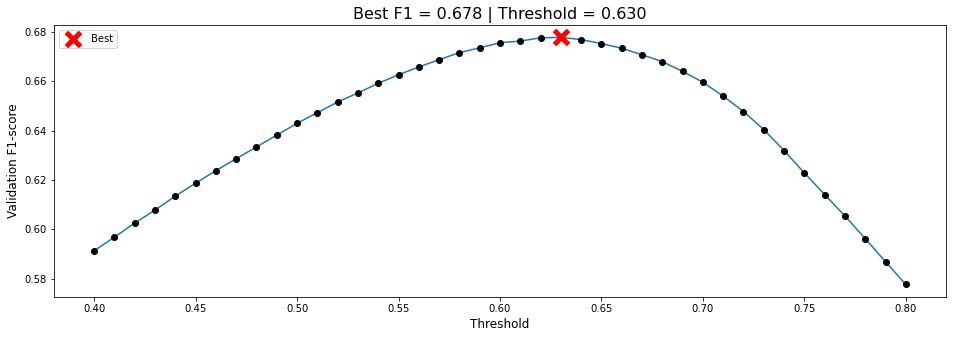

In [15]:
plt.figure(figsize=(16, 5))
plt.scatter(best_threshold, best_score, s=200,
            marker='x', color='red', lw=5, zorder=2)
plt.plot(thresholds, scores, zorder=0)
plt.scatter(thresholds, scores, color='black')
plt.legend(['Best'], loc='upper left')
plt.xlabel("Threshold", size=12)
plt.ylabel("Validation F1-score", size=12)
plt.title(f"Best F1 = {best_score:.3f} | Threshold = {best_threshold:.3f}", size=16)
plt.show()

In [16]:
print(f"Using optimal threshold of {best_threshold:.3f}")
print('-' * 35)
for k in range(18):
    
    # Compute F1 score per question
    preds = (oof[k].values > best_threshold).astype(int)
    m = f1_score(true[k].values, preds, average='macro')
    print(f" Q{k}: F1 = {m:.3f}")
    
preds = (oof.values.reshape((-1)) > best_threshold).astype('int')
m = f1_score(true.values.reshape((-1)), preds, average='macro')
print('-' * 35)
print(f"Overall F1 = {m:.4f}")

Using optimal threshold of 0.630
-----------------------------------
 Q0: F1 = 0.594
 Q1: F1 = 0.495
 Q2: F1 = 0.487
 Q3: F1 = 0.612
 Q4: F1 = 0.566
 Q5: F1 = 0.609
 Q6: F1 = 0.590
 Q7: F1 = 0.523
 Q8: F1 = 0.603
 Q9: F1 = 0.493
 Q10: F1 = 0.593
 Q11: F1 = 0.499
 Q12: F1 = 0.432
 Q13: F1 = 0.607
 Q14: F1 = 0.502
 Q15: F1 = 0.456
 Q16: F1 = 0.546
 Q17: F1 = 0.490
-----------------------------------
Overall F1 = 0.6777


In [17]:
# Retraining
if RETAIN_WITH_ALL_DATA:
    print('\033[1m\033[94m-' * 80, f"\n{' ' * 35}RETRAINING")
    print('-' * 80, '\033[0m')
    
    # Average best trees
    estimators = []
    for q in range(1, 19):
        avg = 0
        for fold in range(1, N_FOLDS + 1):
            avg += best_ntree_limits[f'fold{fold}_q{q}'] / N_FOLDS
        estimators.append(round(avg))
        
    # Disable early stopping
    xgb_params['early_stopping_rounds'] = None

    models = {}
    # Iterate from question 1 to 18
    for q in range(1, 19):   
        # Select the number of estimators
        xgb_params['n_estimators'] = estimators[q - 1]
        
        # Select the question group
        if q <= 3: grp = '0-4'
        elif q <=13: grp = '5-12'
        elif q <= 22: grp = '13-22'

        # Train data
        train_x = df[df.level_group == grp]
        train_y = labels[labels.question == q].set_index('session')

        # Train model
        clf = XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'),
                train_y['correct'],
                verbose=0)

        print(f'Q{q}({clf.best_ntree_limit}), ', end='')

        # Save model
        models[f'{grp}_{q}'] = clf

    print("\nThe models have been retrained using all the data")

else:
    print("No retraining. Models trained with last fold")

No retraining. Models trained with last fold


# Save models

In [22]:
if SAVE:
    # Save the 'models' dictionary as pickle file
    with open("models.pkl", "wb") as f:
        pickle.dump(models, f)
    print("Models saved.")
else:
    print("Models not saved..")

# Inference
The inference should use CPU. It is recommended to set it 

In [25]:
if INFERENCE:
    # Use the competition env
    import jo_wilder
    env = jo_wilder.make_env()
    iter_test = env.iter_test()

    # Clear memory (max allowed 8GB)
    import gc
    del train, labels, df, oof, true
    _ = gc.collect()

    # Predict and create submission file
    limits = {'0-4': (1, 4), '5-12': (4, 14), '13-22': (14, 19)}
    for (sample_submission, test) in iter_test:
        df = feature_engineer(test)
        grp = test.level_group.values[0]
        a, b = limits[grp]
        for q in range(a, b):
            clf = models[f'{grp}_{q}']
            p = clf.predict_proba(df[FEATURES])[:, 1]
            mask = sample_submission.session_id.str.contains(f'q{q}')
            sample_submission.loc[mask, 'correct'] = int(p.item() > best_threshold)
        env.predict(sample_submission)

    # Check submission
    df = pd.read_csv('submission.csv')
    print(df.shape)
    df

else:
    print("No inference. Another notebook will be used")

No inference. Another notebook will be used
